In [ ]:
# !pip install opencv-python
# !pip install numpngw imutils
# !pip install moviepy

In [11]:
import cv2
import json
import numpy as np
import imutils
import sys
import time
import json
import matplotlib
import matplotlib.pyplot as plt
import math
from lib.utils.common_draw_skeletons import *
import pandas as pd
import xml.etree.ElementTree as ET

# Dataset Exploration

## Visualize kinect data

In [2]:
#read Kinect txt file and map it to the correct json format
def read_txt_kinect(path):
    with open(path,'r') as f:
        data = f.read().splitlines()
    f.close()

    tab = {}
    tab1 = {}
    tab1['positions'] = tab

    line = 0
    for i in data:
        line = line+1
        tab[str(float(line))] = {}
        for n in range(25):
            first = i.split(' ')[7*n:7*(n+1)]
            tab[str(float(line))][str(n)] = [first[0], first[1]]
    return tab1

In [3]:
# Draw human skeleton function for Kinect
Body_parts_kinect={0: 'SpineBase' ,1: 'SpineMid',2: 'Neck',3: 'Head',
                       4: 'ShoulderLeft',5: 'ElbowLeft',6: 'WristLeft',7: 'HandLeft',
                       8: 'ShoulderRight',9: 'ElbowRight',10: 'WristRight',
                       11: 'HandRight',12: 'HipLeft',13: 'KneeLeft',14: 'AnkleLeft',
                       15: 'FootLeft',16: 'HipRight',17: 'KneeRight',18: 'AnkleRight',
                       19: 'FootRight',20: 'SpineShoulder',21: 'HandTipLeft',
                       22: 'ThumbLeft',23: 'HandTipRight',24: 'ThumbRight'}
    
# Defining the skeletons pairs
CocoPairsRender_kn = [(0,1),(1,2),(2,3), (2,4),(4,5),(5,6),(6,7),
                    (2,8),(8,9),(9,10),(10,11),(0,12),(12,13),(13,14),
                    (14,15),(0,16),(16,17),(17,18),(18,19)]

def draw_humans_kinect(npimg, humans):

    image_h, image_w = npimg.shape[:2]
    # print(image_h, image_w)
    
    centers = {}
    human_keys=list(map(int, humans.keys()))
    # print(human_keys)
   
    # draw point
    for i in range(len(CocoColors_parts_kn)-1):
            if i not in human_keys:
                # print (i)
                continue
            
            body_part = sklt[str(i)]
            center = (image_w-int((float(body_part[0]) * image_w + 200)/3.5+100), int((float(body_part[1]) * image_h + 200)/3.5+100))
            centers[i] = center
            # print(center)
            
            cv2.circle(npimg, center, 3, CocoColors_parts_kn[i], thickness=2, lineType=8, shift=0)
            
        # draw line
    
    # print(enumerate(CocoPairsRender_kn))
    for pair_order, pair in enumerate(CocoPairsRender_kn):
            # print(pair_order, pair[1])
            # print(pair)
            
            if pair[0] not in human_keys or pair[1] not in human_keys:
                continue
            # print(centers[pair[0]], centers[pair[1]], CocoColors_pairs_kn[pair])
            cv2.line(npimg, centers[pair[0]], centers[pair[1]], CocoColors_pairs_kn[pair], 2)

    return npimg

In [68]:
#initialize jobs
mvt = "cacheTete"
height=300
width=500
size=(width,height)
path_kinect = "dataset/Group1A/kinect/G1A-Kinect-CTK-R1-Brest-038.txt"

In [69]:
########################Prepare Skeletons data#################################
kinect_coord_kn = read_txt_kinect(path_kinect)
print(len(kinect_coord_kn["positions"].keys()))

328


In [74]:
# kinect_coord_kn

In [75]:
# # Extract the relevant data for keys '1' to '24'
# merged_data = []
# for x in range(1,len(kinect_coord_kn['positions'])):
#     merged_data += [list(np.concatenate([np.array(kinect_coord_kn['positions'][str(x)+".0"][str(i)]) for i in range(0, 25)]))]

# # Convert the merged data to a NumPy array
# np_array = np.array(merged_data)

# print(np_array)

In [17]:
#Start plotting skeletons
images=[]
for i in range(1,len(kinect_coord_kn["positions"])):
    ## draw kinect
    black_image_kn = np.zeros((height,width,3), np.uint8)
    sklt = kinect_coord_kn['positions'][str(float(i))]
    frame_image = draw_humans_kinect(black_image_kn,sklt)
    frame_image_kn = cv2.flip(frame_image, 0)
    cv2.putText(frame_image_kn,"Kinect Skeleton", (int(width/8),50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255))
    
    glob = frame_image_kn
    images.append(glob)

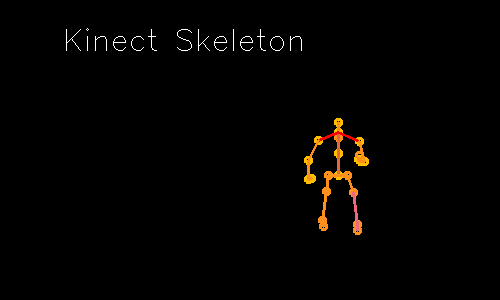

In [18]:
from IPython.display import Image
from numpngw import write_apng

write_apng('outvideo.gif', images, delay=60)
Image(filename='outvideo.gif')

## Dataset Statistics

In [19]:
def readAnnotationFile(path):
	tree = ET.parse(path)
	root = tree.getroot()
	ybin = -1
	ymulti = -1
	for track in root.iter('track'):
		if track.attrib.get('name')=='Global evaluation':
			if track.find('el').find('attribute').text == 'Correct':
				ybin=0
				ymulti=0
				return ybin,ymulti
			else:
				if track.find('el').find('attribute').text == 'Incomplete':
					ybin=1
					ymulti=4
					return ybin,ymulti
				if track.find('el').find('attribute').text == 'Motionless':
					ybin=1
					ymulti=5
					return ybin,ymulti
		else:
			if track.attrib.get('name') =='Global error':
				for attr in track.find('el').iter('attribute'):
					if attr.get('name') == 'type':
						if attr.text == 'Error1':
							ybin=1
							ymulti=1
							return ybin,ymulti
						else:
							if attr.text == 'Error2':
								ybin=1
								ymulti=2
								return ybin,ymulti
							elif attr.text == 'Error3':
								ybin=1
								ymulti=3
								return ybin,ymulti
	return ybin,ymulti

In [20]:
errorNameList = ['Correct','Error1','Error2','Error3','Incomplete','Motionless']
tagList = ['Correct','Error']

In [39]:
import os

groups = ["Group1A","Group2A"]
exercises = ["CTK","ELK","RTK"]

# Create an empty DataFrame
dict = {'Group':[],'Exercise':[], 'Patient':[], 'Place':[], 'Record':[], 'NumFrames':[], 'annotator':[],'label':[]}

df = pd.DataFrame(dict)
for group in groups:
    folder_path = "dataset/"+group + "/" + "kinect"
    file_list = []
    length_list = []
    error_list = []
    # Get the list of files in the specified folder
    for file_name in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file_name)):
            name, data = file_name.split(".")
            columns = name.split("-")
            place = columns[4]
            record = columns[5]

            newRow = {'Group':columns[0],'Exercise':columns[2], 'Patient':columns[3], 'Place':place, 'Record':record, 'NumFrames':0, 'annotator':'Correct','label':0}

            kinect_coord_kn = read_txt_kinect(os.path.join(folder_path, file_name))
            newRow["NumFrames"] = len(kinect_coord_kn["positions"].keys())

            annotation = "dataset/"+group + "/annotatorA/" + '-'.join([columns[0],columns[2],columns[3],place,record])+'.anvil'
            result = readAnnotationFile(annotation)
            newRow["annotator"]=errorNameList[result[1]]
            newRow["label"]=result[0] if result[0]!=-1 else 1
            
            df = pd.concat([df, pd.DataFrame([newRow])], ignore_index=True)

In [40]:
print(df)

    Group Exercise Patient    Place Record  NumFrames   annotator  label
0     G1A      CTK      R1    Brest    022      300.0      Error1    1.0
1     G1A      CTK      R1    Brest    038      328.0     Correct    0.0
2     G1A      CTK      R1    Brest    042      318.0      Error1    1.0
3     G1A      CTK      R1    Brest    054      305.0      Error1    1.0
4     G1A      CTK      R1    Brest    056      298.0      Error1    1.0
..    ...      ...     ...      ...    ...        ...         ...    ...
296   G2A      RTK      S5    Brest    074      312.0     Correct    0.0
297   G2A      RTK      S6  Roscoff    042      416.0  Motionless    1.0
298   G2A      RTK      S6  Roscoff    062      423.0      Error1    1.0
299   G2A      RTK      S6  Roscoff    071      408.0      Error1    1.0
300   G2A      RTK      S6  Roscoff    077      402.0     Correct    0.0

[301 rows x 8 columns]


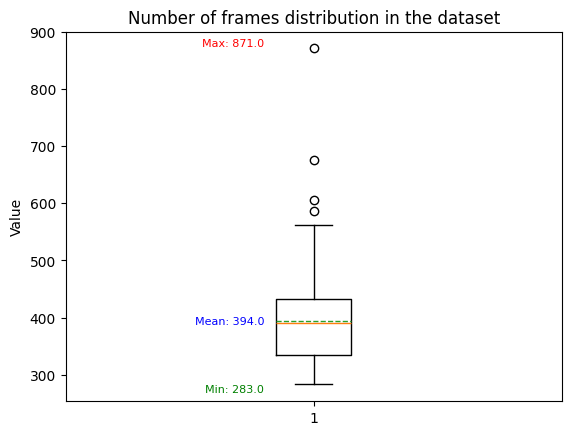

In [47]:
# List of values
values = df["NumFrames"]

# Calculate mean, max, and min
mean_value = round(sum(values) / len(values), 1)
max_value = max(values)
min_value = min(values)

# Create box plot
plt.boxplot([values], showmeans=True, meanline=True)
plt.text(0.9, mean_value, f'Mean: {mean_value}', ha='right', va='center', color='blue', fontsize=8)
plt.text(0.9, max_value, f'Max: {max_value}', ha='right', va='bottom', color='red', fontsize=8)
plt.text(0.9, min_value, f'Min: {min_value}', ha='right', va='top', color='green', fontsize=8)
plt.ylabel('Value')
plt.title('Number of frames distribution in the dataset')
plt.show()

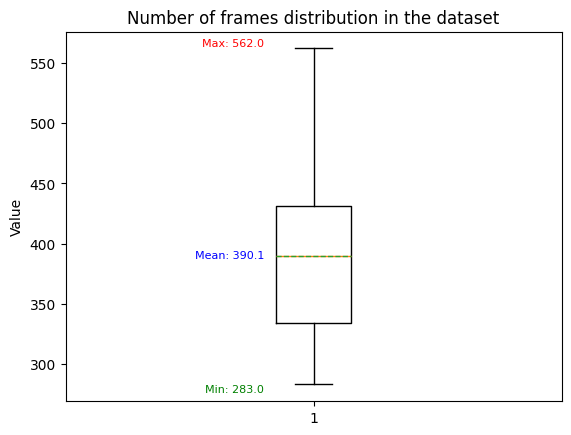

In [48]:
# Sort the DataFrame based on the "NumFrames" column in descending order
df_sorted = df.sort_values('NumFrames', ascending=False)

# Drop the first four rows (largest values) from the sorted DataFrame
df_filtered = df_sorted.iloc[4:]

# List of values
values = df_filtered["NumFrames"]

# Calculate mean, max, and min
mean_value = round(sum(values) / len(values), 1)
max_value = max(values)
min_value = min(values)

# Create box plot
plt.boxplot([values], showmeans=True, meanline=True)
plt.text(0.9, mean_value, f'Mean: {mean_value}', ha='right', va='center', color='blue', fontsize=8)
plt.text(0.9, max_value, f'Max: {max_value}', ha='right', va='bottom', color='red', fontsize=8)
plt.text(0.9, min_value, f'Min: {min_value}', ha='right', va='top', color='green', fontsize=8)
plt.ylabel('Value')
plt.title('Number of frames distribution in the dataset')
plt.show()

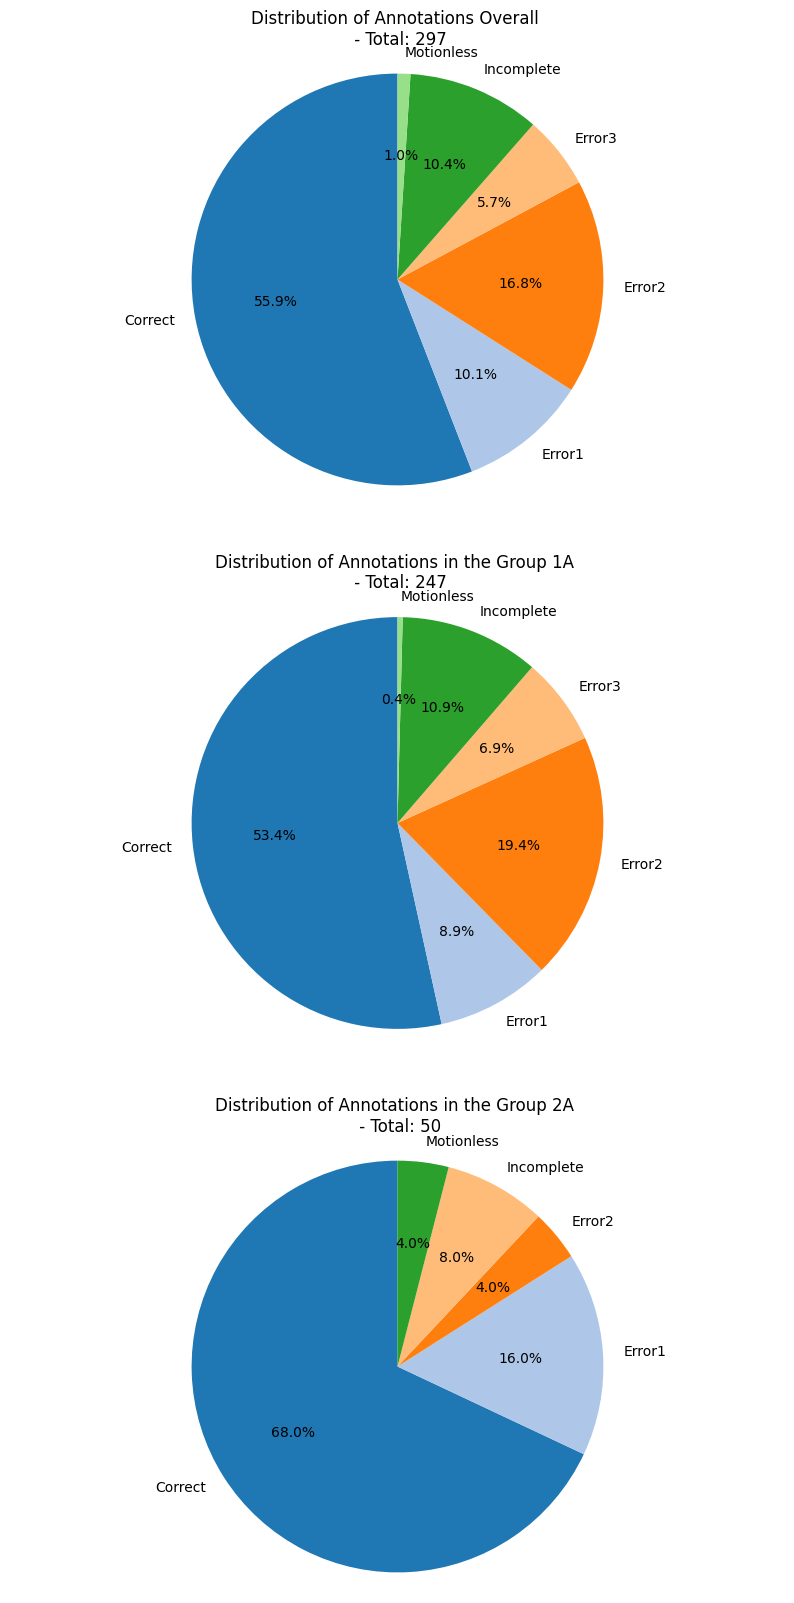

In [65]:
from collections import Counter

# Map numerical values to corresponding names
value_names = {0: 'Correct', 1: 'Error1', 2: 'Error2', 3: 'Error3', 4: 'Incomplete', 5: 'Motionless'}

# Replace numerical values with names
list0 = df_filtered["annotator"]
list1 = df_filtered[df_filtered["Group"]=="G1A"]["annotator"]
list2 = df_filtered[df_filtered["Group"]=="G2A"]["annotator"]

# named_values_list_0 = [value_names[value] for value in list0]
# named_values_list_1 = [value_names[value] for value in list1]
# named_values_list_2 = [value_names[value] for value in list2]


# Count the occurrences of each value in the list
value_counts_0 = Counter(list0)
value_counts_1 = Counter(list1)
value_counts_2 = Counter(list2)


# Get the values and corresponding counts sorted by label value
labels_0 = [label for label in sorted(value_names.values()) if value_counts_0[label] > 0]
counts_0 = [value_counts_0[label] for label in labels_0]

labels_1 = [label for label in sorted(value_names.values()) if value_counts_1[label] > 0]
counts_1 = [value_counts_1[label] for label in labels_1]

labels_2 = [label for label in sorted(value_names.values()) if value_counts_2[label] > 0]
counts_2 = [value_counts_2[label] for label in labels_2]

# Define custom colors for the labels
colors = plt.cm.tab20.colors[:len(labels_1)]  # Adjust based on the number of labels

# Plot a circle chart based on the counts
fig, ax = plt.subplots(3, 1, figsize=(10, 20))
ax[0].pie(counts_0, labels=labels_0, autopct='%1.1f%%', startangle=90,colors=colors)
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[0].set_title('Distribution of Annotations Overall \n - Total: ' + str(len(list0)))

ax[1].pie(counts_1, labels=labels_1, autopct='%1.1f%%', startangle=90,colors=colors)
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[1].set_title('Distribution of Annotations in the Group 1A \n - Total: ' + str(len(list1)))

ax[2].pie(counts_2, labels=labels_2, autopct='%1.1f%%', startangle=90,colors=colors)
ax[2].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[2].set_title('Distribution of Annotations in the Group 2A \n - Total: ' + str(len(list2)))

# Display the plot
plt.show()

In [66]:
# Export the DataFrame to a CSV file
df_filtered.to_csv('keraalTable.csv', index=False)

# Print a message to confirm the export
print("DataFrame exported to 'keraalTable.csv'")

DataFrame exported to 'keraalTable.csv'


# Train Model

## Set up

In [29]:
import numpy as np
from scipy import signal
import xml.etree.ElementTree as ET
import os, sys
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import math

import matplotlib.cm as cm
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.models import load_model
import random

2024-12-19 14:29:45.840270: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-19 14:29:45.995889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-19 14:29:46.051543: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-19 14:29:46.068314: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 14:29:46.179300: I tensorflow/core/platform/cpu_feature_guar

In [30]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


I0000 00:00:1734618593.424622    4736 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734618593.475640    4736 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734618593.475695    4736 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734618594.973340    4736 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734618594.973417    4736 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-19

True

In [102]:
groups = ["Group1A","Group2A"]
GRs = ["G1A","G2A"]
exercises = ["CTK","ELK","RTK"]
def getKinectPath(row):
	group = groups[GRs.index(row["Group"])]
	
	filename = '-'.join([row["Group"],'Kinect',row["Exercise"],row["Patient"],row["Place"],"{:03d}".format(row["Record"])]) +'.txt'

	return '/'.join(["dataset",group,'kinect',filename]),row["Exercise"]
	

errorNameList = ['Correct','Error1','Error2','Error3','Incomplete','Motionless']
def getAnnotation(row):
	return errorNameList.index(row['annotator']) if row['annotator'] in errorNameList else 0

def load_dataset(dfTrain, dfTest, padding):
	# train
	x_train_list=[]
	y_train_list=[]

	pathTrain = dfTrain.apply(getKinectPath, axis=1).tolist()
	annotation_train = dfTrain.apply(getAnnotation, axis=1).tolist()

	for i in range(len(pathTrain)):
		data = load_skeleton_data_processed(pathTrain[i][0])
		exercise = pathTrain[i][1]
		data = np.insert(data, 0, exercises.index(exercise), axis=1)
		data = interpolate(data,padding)
		x_train_list.append(data)
		y_train_list.append(annotation_train[i])

	x_train_list = np.asarray(x_train_list)
	y_train_list = np.asarray(y_train_list)

	# test
	x_test_list=[]
	y_test_list=[]

	pathTest = dfTest.apply(getKinectPath, axis=1).tolist()
	annotation_test = dfTest.apply(getAnnotation, axis=1).tolist()

	for i in range(len(pathTest)):
		data = load_skeleton_data_processed(pathTest[i][0])
		exercise = pathTest[i][1]
		data = np.insert(data, 0, exercises.index(exercise), axis=1)
		data = interpolate(data,padding)
		x_test_list.append(data)
		y_test_list.append(annotation_test[i])
	
	x_test_list = np.asarray(x_test_list)
	y_test_list = np.asarray(y_test_list)

	return x_train_list,y_train_list,x_test_list,y_test_list

def load_skeleton_data_processed(path):
	kinect_coord_kn = read_txt_kinect(path)
	# Extract the relevant data for keys '0' to '24'
	merged_data = []
	for x in range(1,len(kinect_coord_kn['positions'])):
		merged_data += [list(np.concatenate([np.array(kinect_coord_kn['positions'][str(x)+".0"][str(i)]) for i in range(0, 25)]))]

	# Convert the merged data to a NumPy array
	data = np.array(merged_data)
	data = data.astype(float)
	return data

def paddingArray(data, padding):
	# Find the maximum number of rows in the data
	max_rows = padding

	# Pad or truncate each array in the list to have the same number of rows
	data_padded = [np.pad(arr, ((0, max_rows - arr.shape[0]), (0, 0)), mode='constant', constant_values=0) for arr in data]
	return data_padded

def interpolate(data, max_rows):
	df = pd.DataFrame(data)
	# Repeat the last row until reaching max_rows
	while len(df) < max_rows:
		last_row = df.iloc[-1]
		df = pd.concat([df, pd.DataFrame([last_row], columns=df.columns)], ignore_index=True)
	return df.to_numpy()
	# interpolated_df = df.reindex(range(max_rows)).interpolate(method='linear')
	# return interpolated_df.to_numpy()

In [91]:
class LSTM_CLASSIF:

    def __init__(self, input_shape, num_layers, neurons, build=True,output_shape=4):
        self.neurons = neurons
        self.output_shape = output_shape

        if build == True:
            self.model = self.build_model(input_shape, num_layers, neurons)
            self.model.summary()

    def build_model(self, input_shape, num_layers, neurons):
        inputs = tf.keras.layers.Input(input_shape, name='inputs')

        # lstm layers, intermediate layers return sequences of hidden states, last layer returns last hidden state only
        if num_layers>1:
            # first lstm layer
            lstm_enc_output = tf.keras.layers.LSTM(neurons, name='lstm_enc_1', return_sequences=True)(inputs)
            # other lstm layers if num_layers>1
            for l in range(2,num_layers):
                name_layer = 'lstm_enc_' + str(l)
                lstm_enc_output = tf.keras.layers.LSTM(neurons, name=name_layer, return_sequences=True)(lstm_enc_output)
            # last layer (return last hidden state)
            name_layer = 'lstm_enc_' + str(num_layers)
            lstm_enc_output = tf.keras.layers.LSTM(neurons, name=name_layer, return_sequences=False)(lstm_enc_output)
        else:
            lstm_enc_output = tf.keras.layers.LSTM(neurons, name='lstm_enc_1', return_sequences=False)(inputs)

        outputs = tf.keras.layers.Dense(self.output_shape,activation='softmax')(lstm_enc_output)
        
        model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

        optimizer = tf.keras.optimizers.Adam(1e-3)

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        return model
        
    def fit(self, x_train, y_train, batch_size, nb_epochs):
        hist = self.model.fit(x_train,y_train, batch_size=batch_size, epochs=nb_epochs, verbose=True)
        return hist

    def predict(self, x_test):
        y_pred = self.model.predict(x_test)
        return y_pred

    def evaluate(self, x_test, y_true):
        loss, acc = self.model.evaluate(x_test,y_true)
        return loss, acc
    
    def save(self, path):
        self.model.save(path)


In [103]:
# data = load_skeleton_data_processed("dataset/Group1A/kinect/G1A-Kinect-CTK-R1-Brest-022.txt")
# data

In [92]:
df = pd.read_csv("keraalTable.csv")
df

,Group,Exercise,Patient,Place,Record,NumFrames,annotator,label
0,G1A,ELK,R4,Roscoff,54,562.0,Error2,1.0
1,G1A,ELK,R6,Roscoff,43,562.0,Correct,0.0
2,G1A,ELK,R6,Roscoff,18,560.0,Incomplete,1.0
3,G2A,ELK,S3,Roscoff,7,560.0,Incomplete,1.0
4,G1A,ELK,R6,Roscoff,89,553.0,Correct,0.0
...,...,...,...,...,...,...,...,...
292,G1A,CTK,R2,Brest,65,286.0,Error1,1.0
293,G1A,RTK,R2,Brest,93,286.0,Correct,0.0
294,G1A,RTK,R1,Brest,32,285.0,Correct,0.0
295,G1A,RTK,R1,Brest,19,284.0,Error2,1.0


In [94]:
padding = max(df["NumFrames"])
print(padding)

562.0


## Train model to predict annotation

In [104]:
df_sub = df

df_subTrain, df_subTest = train_test_split(df_sub, test_size=0.2, random_state=42)

x_train,y_train,x_test,y_multi = load_dataset(df_subTrain,df_subTest, padding)

# modidy labels to one-hot vectors
LE_encoder = LabelEncoder()
OHE_encoder = OneHotEncoder(categories=[range(6)])

y_train_test = np.concatenate((y_train,y_multi),axis =0)
new_y_train_test = LE_encoder.fit_transform(y_train_test)

new_y_train_test = OHE_encoder.fit_transform(new_y_train_test.reshape(-1,1))
new_y_train = new_y_train_test[0:len(y_train)].toarray()
new_y_test = new_y_train_test[len(y_train):].toarray()
# print('new_y_train',new_y_train.shape) 
# print('new_y_test',new_y_test.shape)

input_shape=x_train.shape[1:]
print(input_shape)

neurons=512
num_layers=3

model = LSTM_CLASSIF(input_shape, num_layers, neurons=neurons,output_shape=6)

batch_size = 32
num_epochs = 100

hist = model.fit(x_train,new_y_train,batch_size,num_epochs)

loss, acc = model.evaluate(x_test,new_y_test)
print("Loss: ",loss)
print("Accuracy: ",acc)
name = "Annotator"

model.save("model_LSTM_classifer_"+name+".keras")

del model

(562, 51)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 562, 51)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_enc_1 (LSTM)               │ (None, 562, 512)       │     1,155,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_enc_2 (LSTM)               │ (None, 562, 512)       │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_enc_3 (LSTM)               │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,356,550 (20.43 MB)

 Trainable params: 5,356,550 (20.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


2024-12-19 16:13:49.633590: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 279ms/step - accuracy: 0.2904 - loss: 1.5679
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.5335 - loss: 1.1646
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step - accuracy: 0.5760 - loss: 1.1124
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - accuracy: 0.5895 - loss: 0.9942
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.5692 - loss: 1.0786
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 482ms/step - accuracy: 0.6065 - loss: 0.9040
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - accuracy: 0.5563 - loss: 0.9953
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.6199 - loss: 0.9349
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.6404 - loss: 0.9182
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - accuracy: 0.6790 - loss: 0.8469
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - accuracy: 0.5767 - loss: 1.0326
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - accuracy: 0.6272 - l

## Train model to predict label

In [107]:
y_train[y_train > 1] = 1
y_multi[y_multi > 1] = 1

# modidy labels to one-hot vectors
LE_encoder = LabelEncoder()
OHE_encoder = OneHotEncoder(categories=[range(2)])

y_train_test = np.concatenate((y_train,y_multi),axis =0)
new_y_train_test = LE_encoder.fit_transform(y_train_test)

new_y_train_test = OHE_encoder.fit_transform(new_y_train_test.reshape(-1,1))
new_y_train = new_y_train_test[0:len(y_train)].toarray()
new_y_test = new_y_train_test[len(y_train):].toarray()
# print('new_y_train',new_y_train.shape) 
# print('new_y_test',new_y_test.shape)

input_shape=x_train.shape[1:]
print(input_shape)

neurons=512
num_layers=3

model = LSTM_CLASSIF(input_shape, num_layers, neurons=neurons,output_shape=2)

batch_size = 32
num_epochs = 100

hist = model.fit(x_train,new_y_train,batch_size,num_epochs)

loss, acc = model.evaluate(x_test,new_y_test)
print("Loss: ",loss)
print("Accuracy: ",acc)
name = "Label"

model.save("model_LSTM_classifer_"+name+".keras")

del model

(562, 51)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 562, 51)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_enc_1 (LSTM)               │ (None, 562, 512)       │     1,155,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_enc_2 (LSTM)               │ (None, 562, 512)       │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_enc_3 (LSTM)               │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,354,498 (20.43 MB)

 Trainable params: 5,354,498 (20.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.5699 - loss: 0.7082
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.5424 - loss: 0.6672
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.5838 - loss: 0.6762
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.5916 - loss: 0.6878
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.6683 - loss: 0.6541
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.5524 - loss: 0.6643
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.5565 - loss: 0.5883
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - accuracy: 0.6489 - loss: 0.6760
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 513ms/step - accuracy: 0.6287 - loss: 0.6372
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - accuracy: 0.6185 - loss: 0.6089
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - accuracy: 0.6455 - loss: 0.5985
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy:

## Evaluation

In [124]:
def predict_error(model,output_size,pad,dataTest):
    # if dataTrain==None:
    #     dataTrain=dataTest
    x_train,y_train,x_test,y_multi = load_dataset(dataTest,dataTest, pad)
    # modidy labels to one-hot vectors
    if output_size < 6:
        y_train[y_train > 1] = 1
        y_multi[y_multi > 1] = 1
    LE_encoder = LabelEncoder()
    OHE_encoder = OneHotEncoder(categories=[range(output_size)])

    y_train_test = np.concatenate((y_train,y_multi),axis =0)
    new_y_train_test = LE_encoder.fit_transform(y_train_test)

    new_y_train_test = OHE_encoder.fit_transform(new_y_train_test.reshape(-1,1))
    new_y_train = new_y_train_test[0:len(y_train)].toarray()
    new_y_test = new_y_train_test[len(y_train):].toarray()

    result = model.predict(x_test)

    # Assuming y_train and y_multi are the original labels

    # Inverse transform one-hot encoded labels back to label indices using the OneHotEncoder
    decoded_labels = OHE_encoder.inverse_transform(result)

    # Inverse transform label indices back to original labels using the LabelEncoder
    decoded_labels = LE_encoder.fit_transform(decoded_labels.reshape(-1, 1))

    decoded_labels

    predicted_result = decoded_labels.tolist()
    true_result = y_multi

    return predicted_result, true_result

In [108]:
modelAnnotator = load_model('model_LSTM_classifer_Annotator.keras')
modelLabel = load_model('model_LSTM_classifer_Label.keras')

In [116]:
dfTest = df_subTest
dfTrain = df_subTrain

In [125]:
result_predicted = []
result_true = []
count = 0
for model, o in zip([modelAnnotator,modelLabel],[6,2]):
    print(o)
    output = predict_error(model,o,padding,dfTest)

    result_predicted.append(output[0])
    result_true.append(output[1])

6
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
2


/home/dsa/miniconda3/envs/tf217/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step


/home/dsa/miniconda3/envs/tf217/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [132]:
accuracy = []
for i in range(2):
    count = 0
    size = len(result_predicted[i])
    for p,t in zip(result_predicted[i],result_true[i]):
        if p == t:
            count+=1
    accr = round((count/size)*100,1)
    accuracy.append(accr)

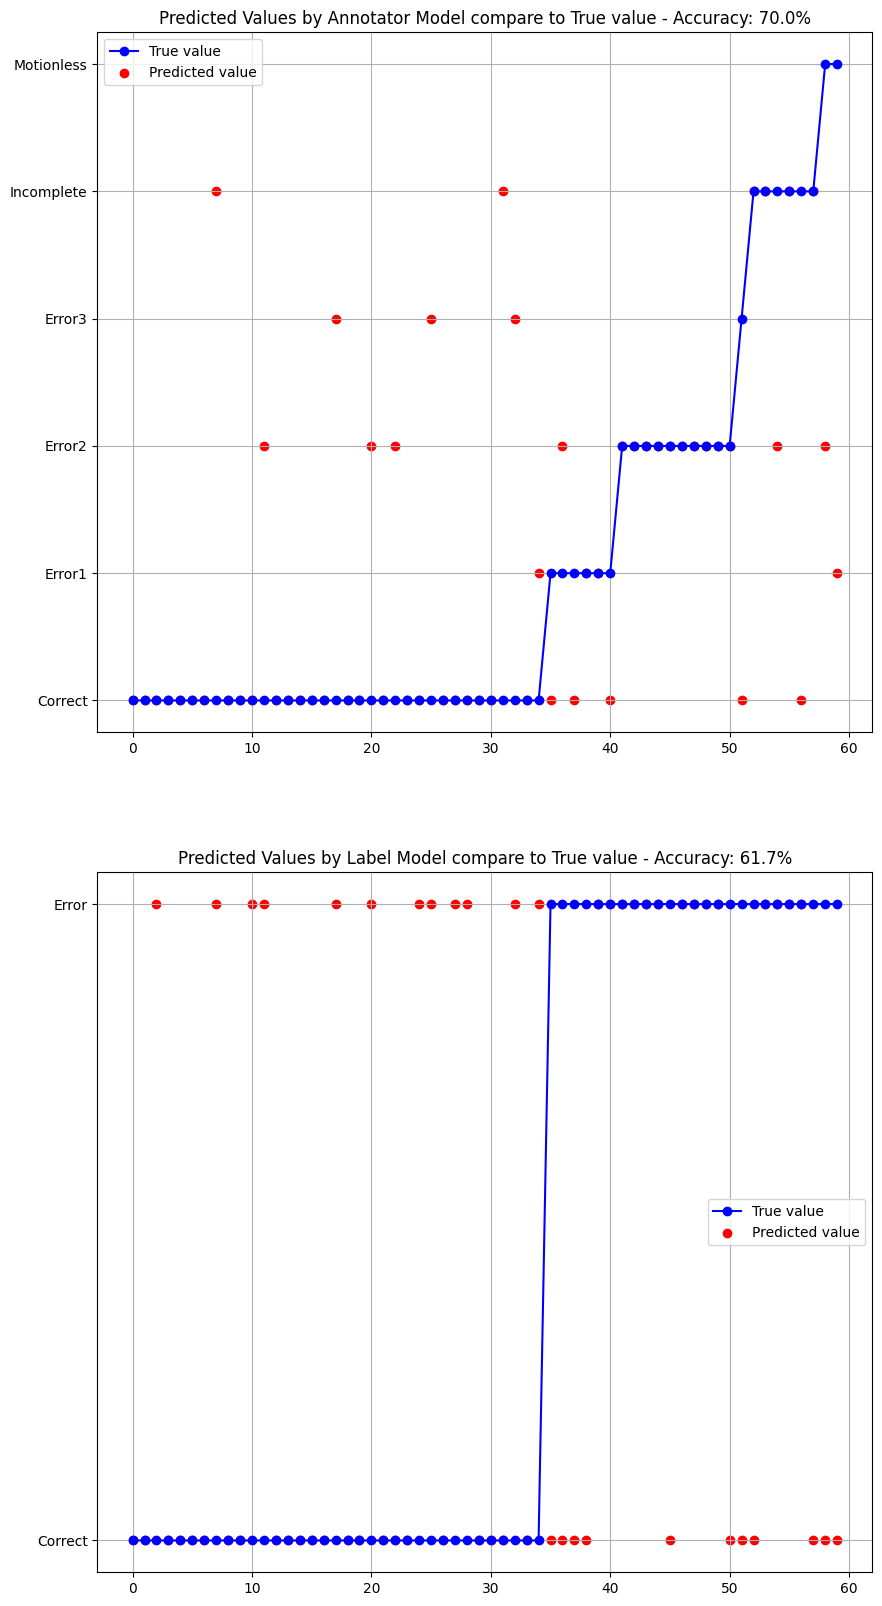

In [137]:
# Assuming list1 is the predicted values and list2 is the true values
predictL = []
trueL = []
for i in range(2):
    predicted_values = result_predicted[i]
    true_values = result_true[i]

    # Sort the predicted values and reorder the true values accordingly
    sorted_indices = sorted(range(len(true_values)), key=lambda k: true_values[k])
    sorted_true = [true_values[i] for i in sorted_indices]
    reordered_predicted = [predicted_values[i] for i in sorted_indices]

    trueL.append(sorted_true)
    predictL.append(reordered_predicted)

# Define custom y-axis labels for ax[0] and ax[1]
labels_ax0 = {0: 'Correct', 1: 'Error1', 2: 'Error2', 3: 'Error3', 4: 'Incomplete', 5: 'Motionless'}
labels_ax1 = {0: 'Correct', 1: 'Error'}

# Plot the sorted predicted values as a line and the reordered true values as a scatter plot
fig, ax = plt.subplots(2, 1, figsize=(10, 20))
ax[0].plot(range(len(trueL[0])), trueL[0], color='blue', marker='o', label='True value')
ax[0].scatter(range(len(predictL[0])), predictL[0], color='red', label='Predicted value')
ax[0].set_title('Predicted Values by Annotator Model compare to True value - Accuracy: '+str(accuracy[0])+'%')
ax[0].set_yticks(list(labels_ax0.keys()))
ax[0].set_yticklabels(list(labels_ax0.values()))
ax[0].legend()
ax[0].grid(True)

ax[1].plot(range(len(trueL[1])), trueL[1], color='blue', marker='o', label='True value')
ax[1].scatter(range(len(predictL[1])), predictL[1], color='red', label='Predicted value')
ax[1].set_title('Predicted Values by Label Model compare to True value - Accuracy: '+str(accuracy[1])+'%')
ax[1].set_yticks(list(labels_ax1.keys()))
ax[1].set_yticklabels(list(labels_ax1.values()))
ax[1].legend()
ax[1].grid(True)

plt.show()